# Forest Cover Type Classification

**Goal:** Build a system that predicts the forest cover type for a 30m x 30m patch of land using the provided CSV (`train.csv`).

This notebook includes:
- Data loading & inspection
- Statistical summary and visualization
- Handling missing values and duplicates
- Outlier detection and handling (IQR method)
- Feature engineering & selection (correlation, SelectKBest, RandomForest importance)
- Model building: Logistic Regression, K-Nearest Neighbors, Support Vector Machine, Random Forest, Gradient Boosting
- Model evaluation (accuracy, classification report, confusion matrix, cross-validation)
- Saving the best model


In [1]:
# Imports and global settings
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib



In [2]:
# Load dataset
data =pd.read_csv('train.csv')
df = pd.DataFrame(data)
print('Loaded dataset with shape:', df.shape)
df.head()

Loaded dataset with shape: (15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [3]:
# Basic information and statistical summary
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

None

In [4]:
display(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
Id,15120.0,7560.500000,4364.912370,1.0,3780.75,7560.5,11340.25,15120.0
Elevation,15120.0,2749.322553,417.678187,1863.0,2376.00,2752.0,3104.00,3849.0
Aspect,15120.0,156.676653,110.085801,0.0,65.00,126.0,261.00,360.0
Slope,15120.0,16.501587,8.453927,0.0,10.00,15.0,22.00,52.0
Horizontal_Distance_To_Hydrology,15120.0,227.195701,210.075296,0.0,67.00,180.0,330.00,1343.0
Vertical_Distance_To_Hydrology,15120.0,51.076521,61.239406,-146.0,5.00,32.0,79.00,554.0
Horizontal_Distance_To_Roadways,15120.0,1714.023214,1325.066358,0.0,764.00,1316.0,2270.00,6890.0
Hillshade_9am,15120.0,212.704299,30.561287,0.0,196.00,220.0,235.00,254.0
Hillshade_Noon,15120.0,218.965608,22.801966,99.0,207.00,223.0,235.00,254.0
Hillshade_3pm,15120.0,135.091997,45.895189,0.0,106.00,138.0,167.00,248.0


In [5]:
# Check missing values and duplicates
missing = df.isnull().sum()
missing = missing[missing>0].sort_values(ascending=False)
print('Missing values:\n', missing if not missing.empty else 'No missing values found.')

dups = df.duplicated().sum()
print('\nNumber of duplicate rows:', dups)

Missing values:
 No missing values found.

Number of duplicate rows: 0


## 📊 Data Visualization using Matplotlib and Seaborn

Let's visualize the dataset to better understand feature distributions, relationships, and patterns.

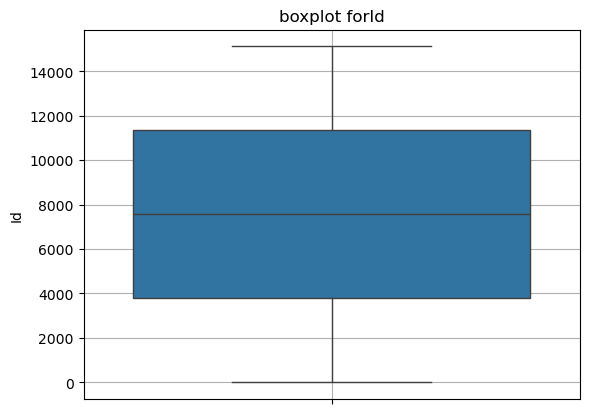

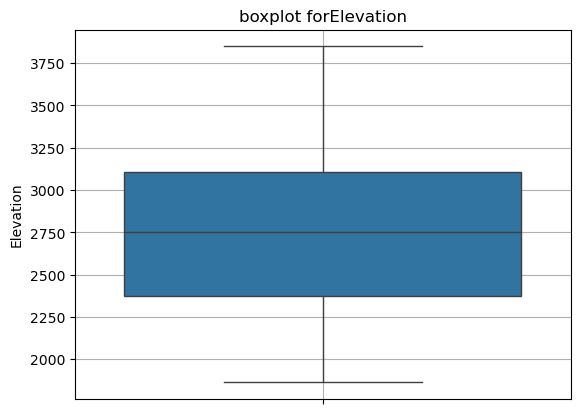

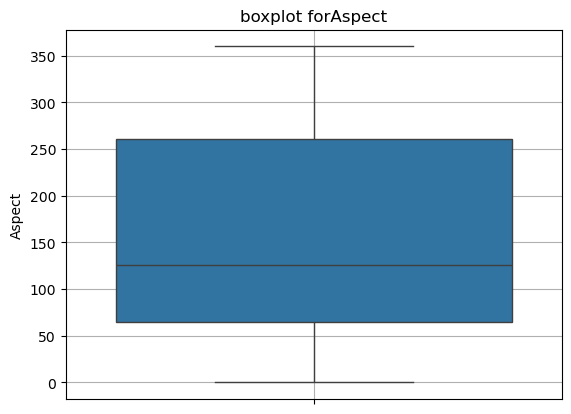

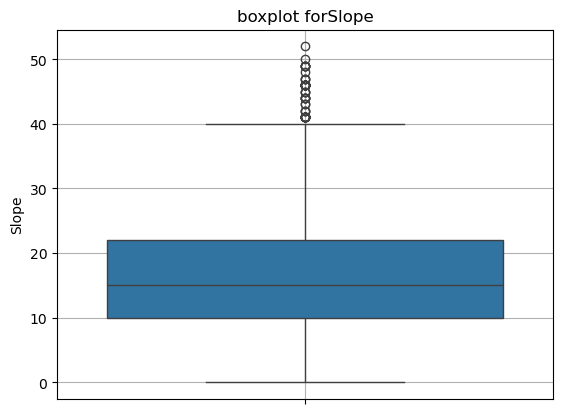

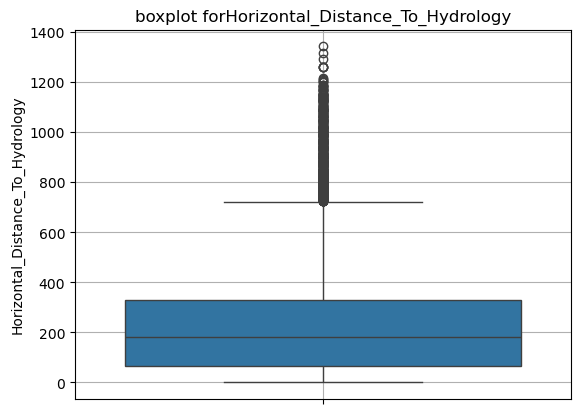

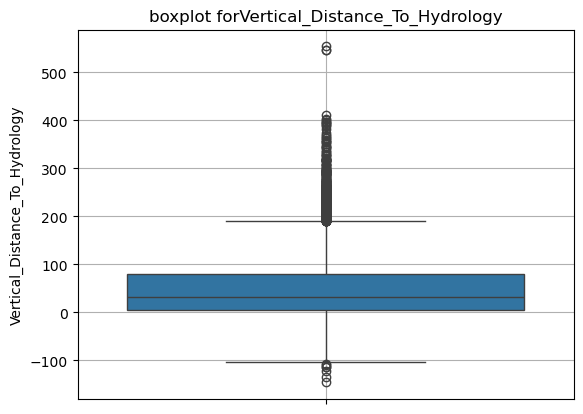

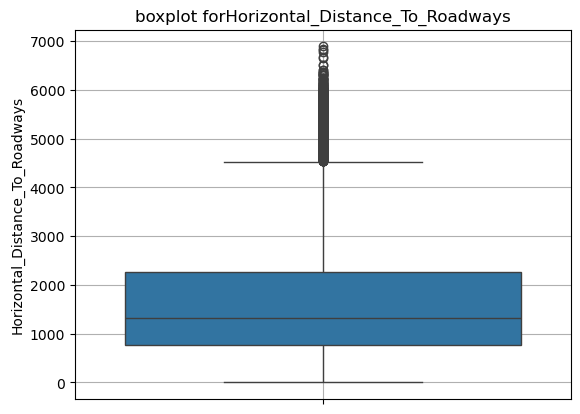

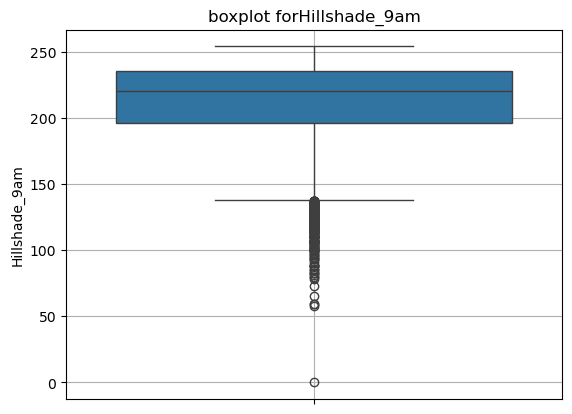

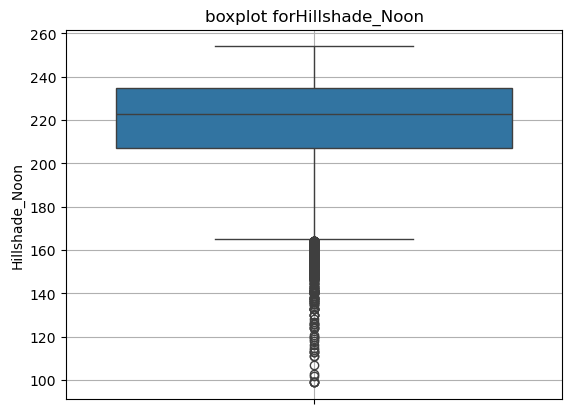

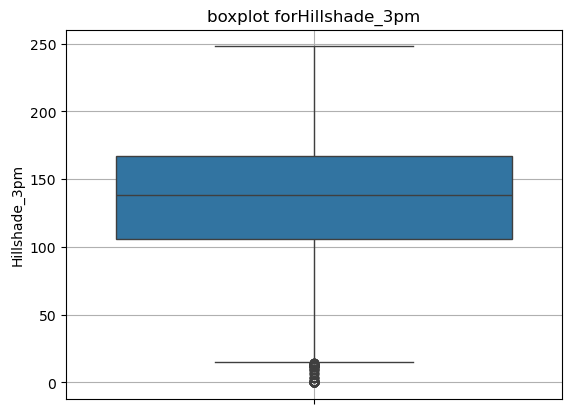

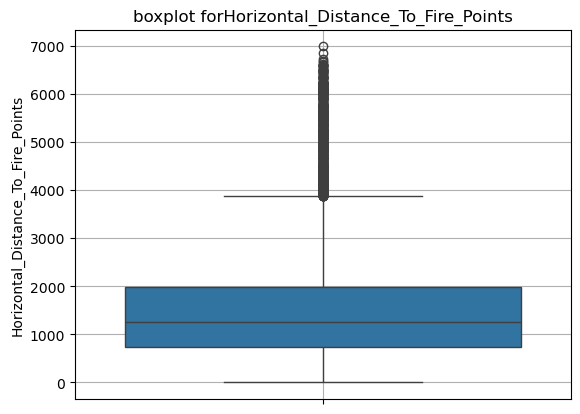

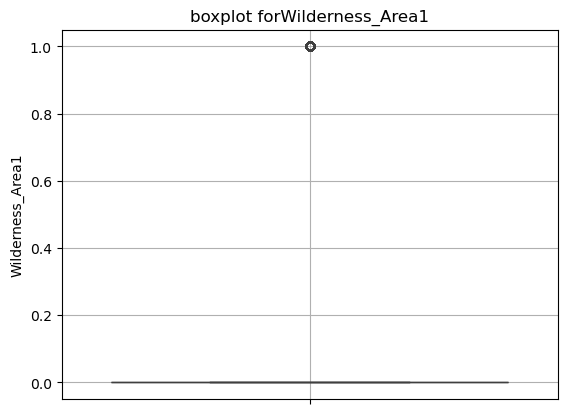

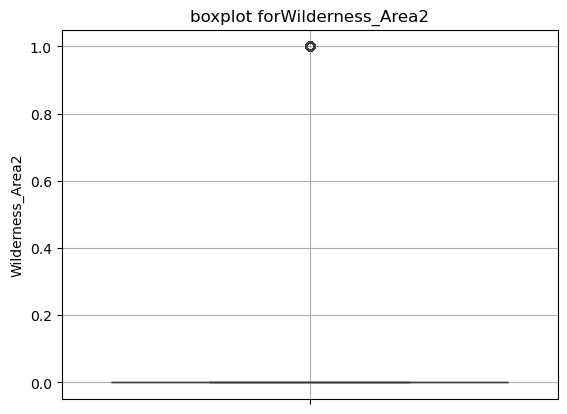

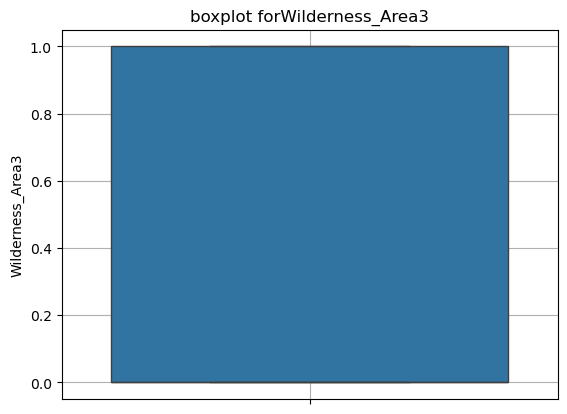

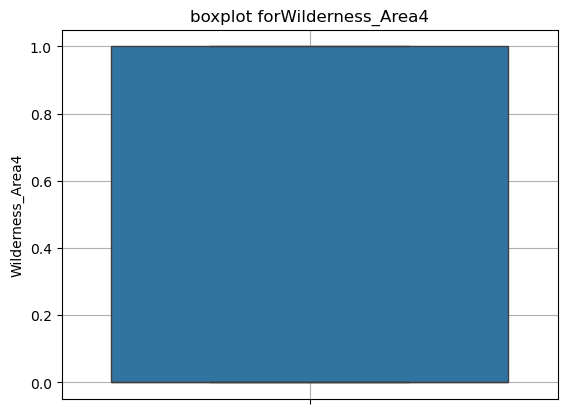

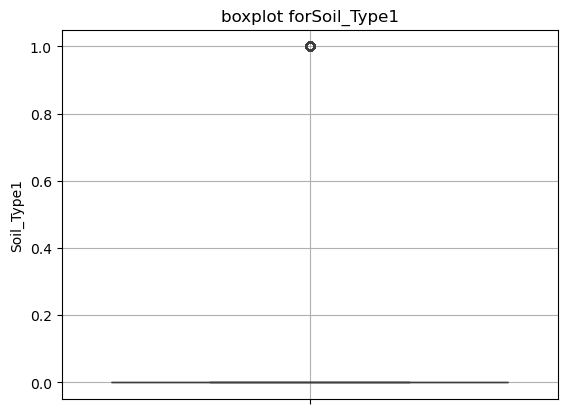

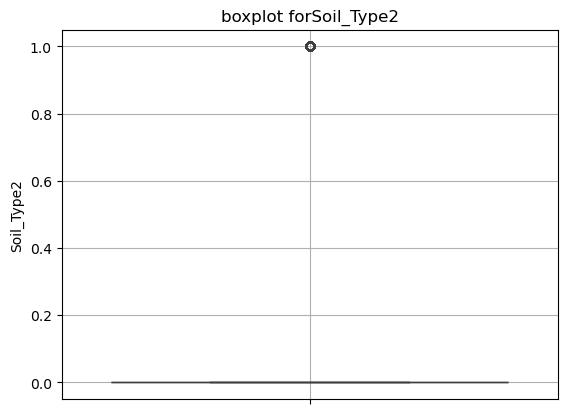

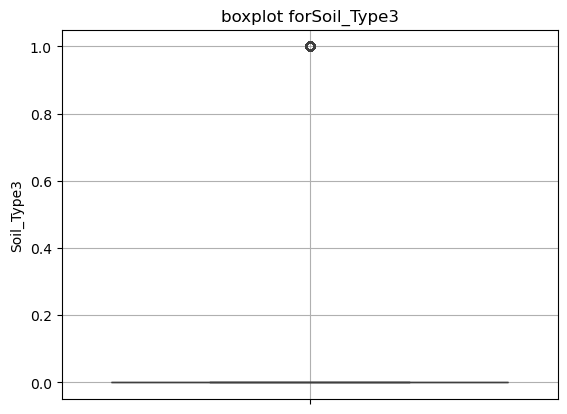

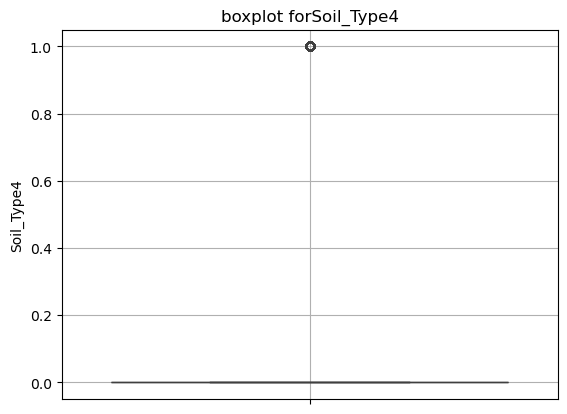

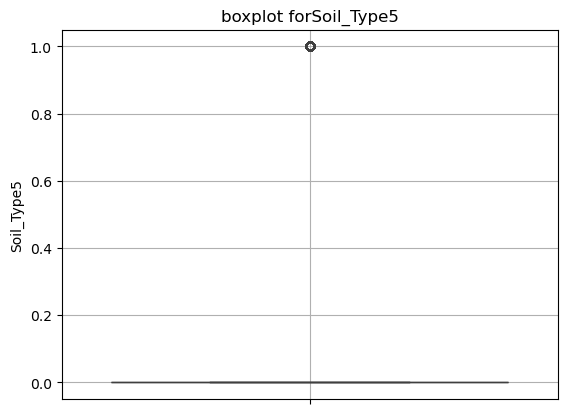

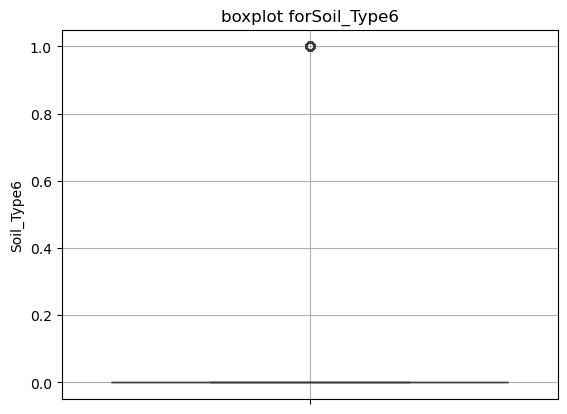

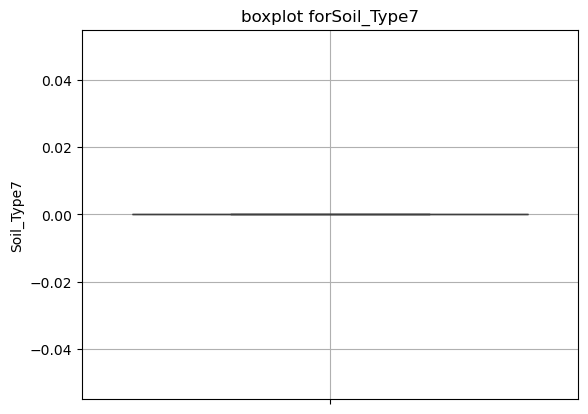

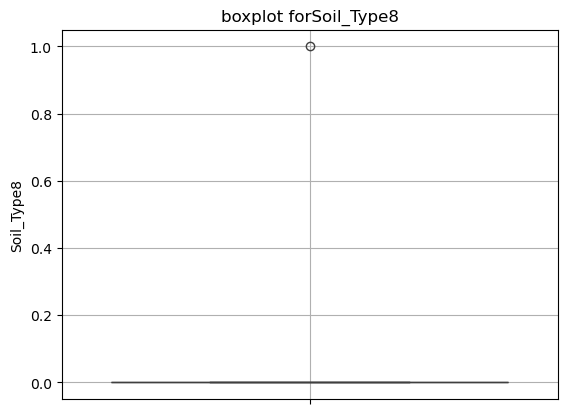

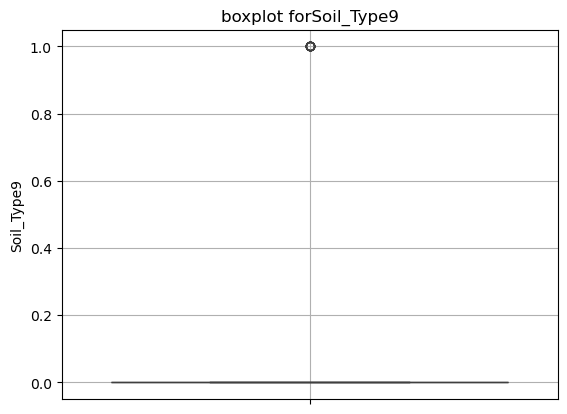

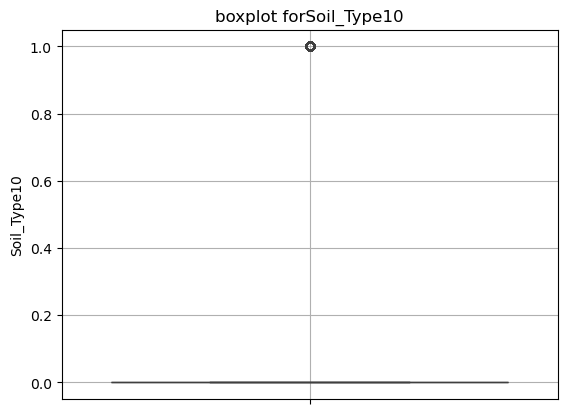

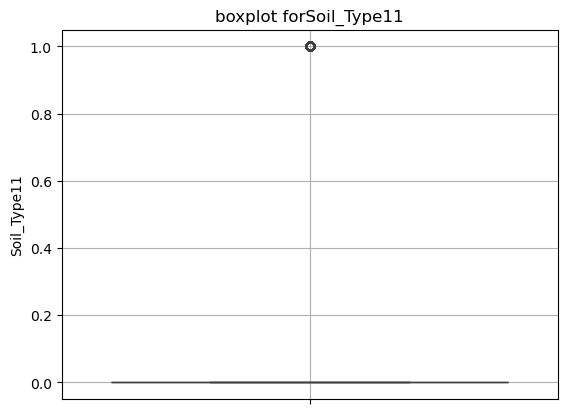

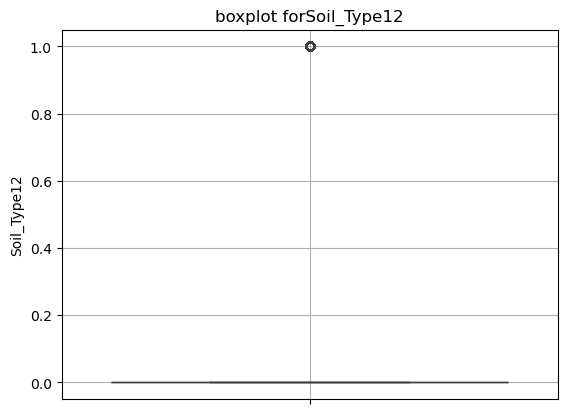

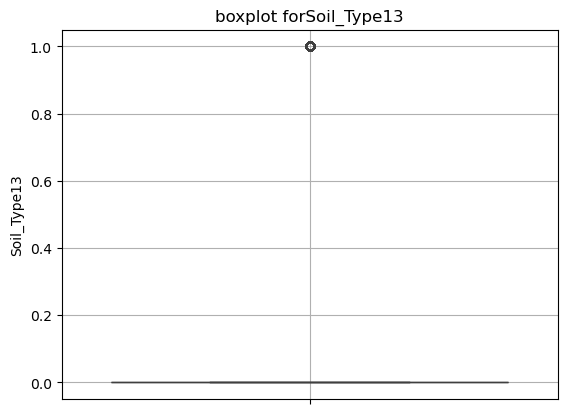

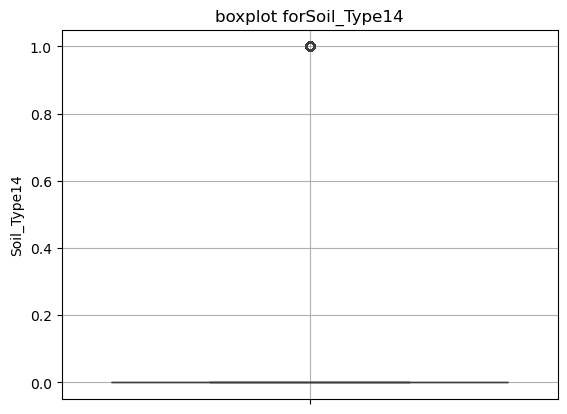

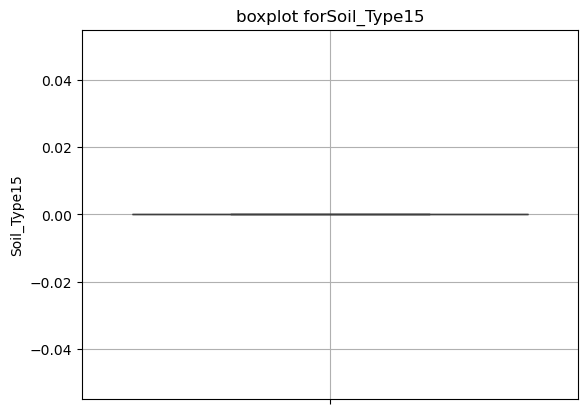

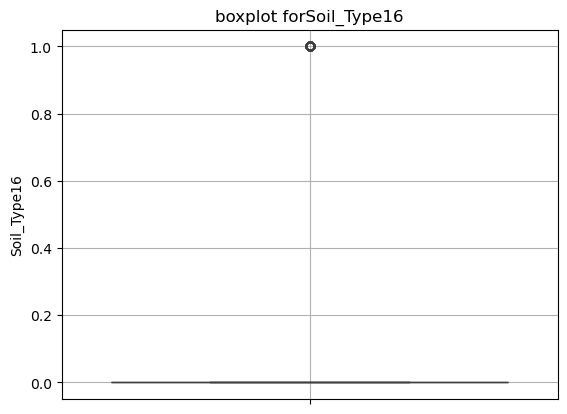

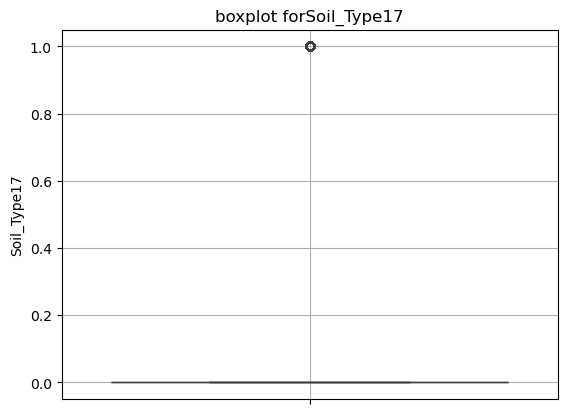

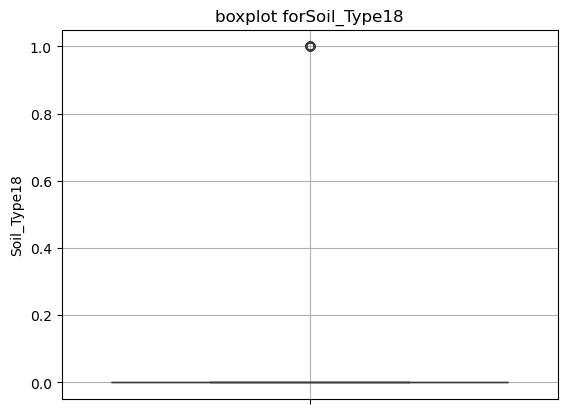

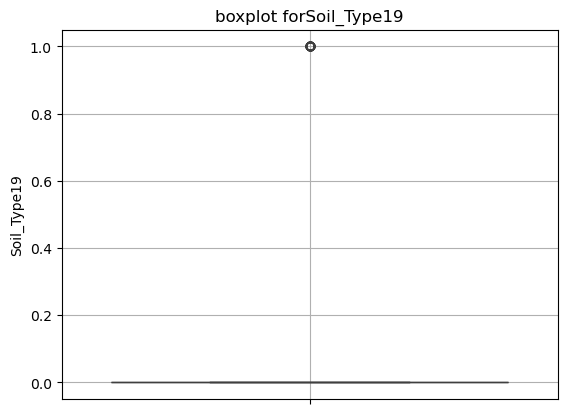

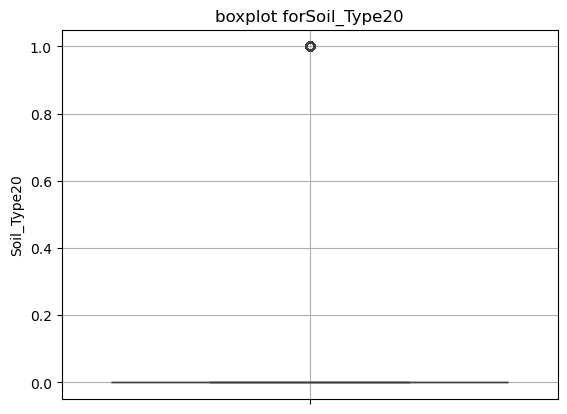

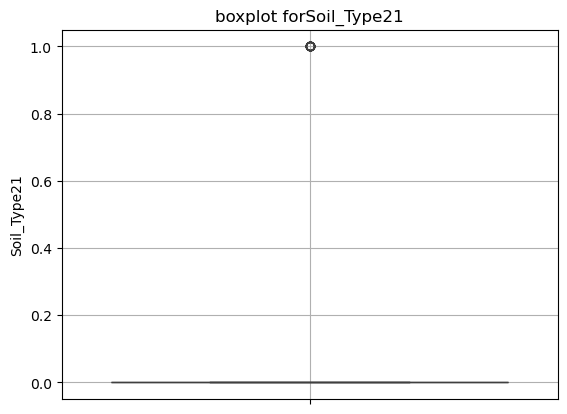

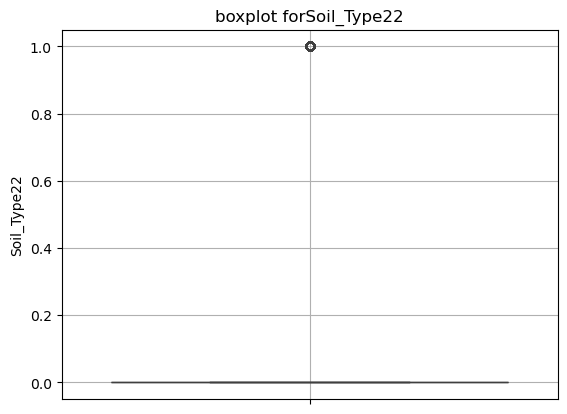

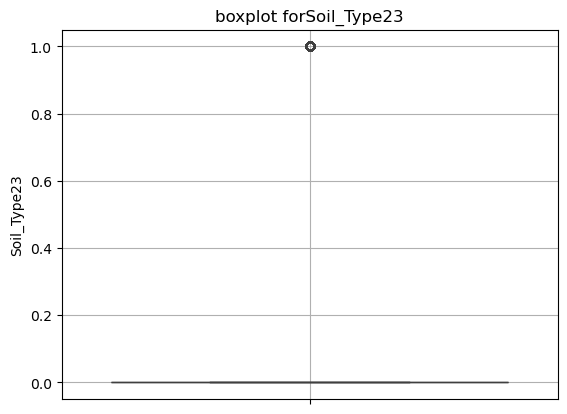

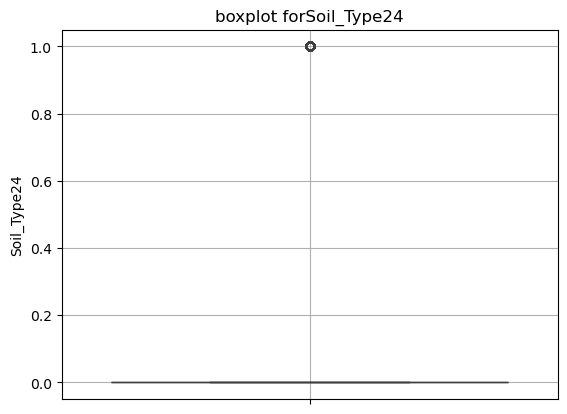

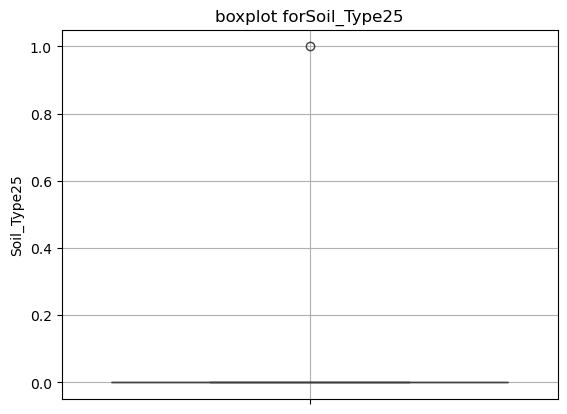

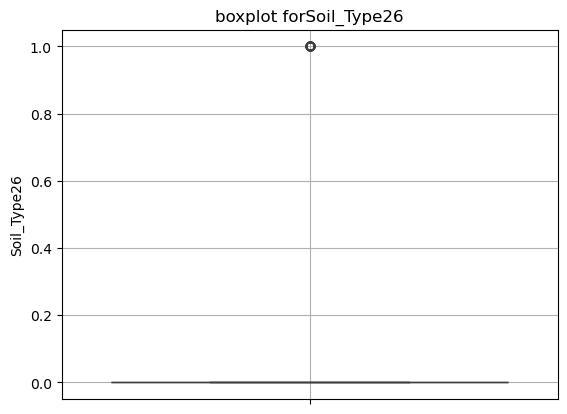

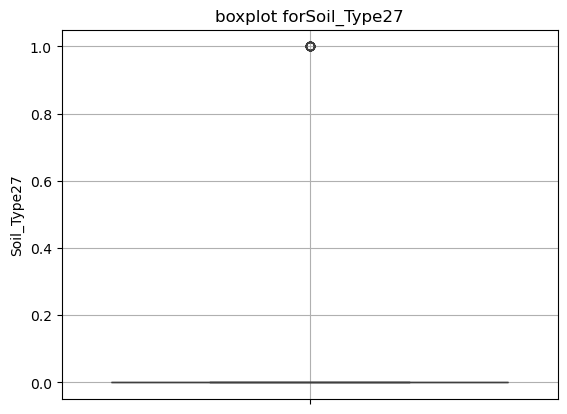

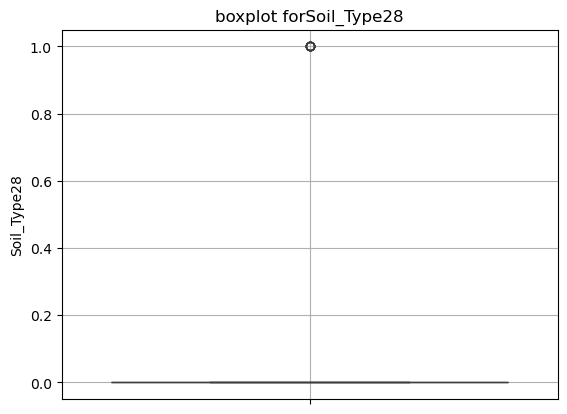

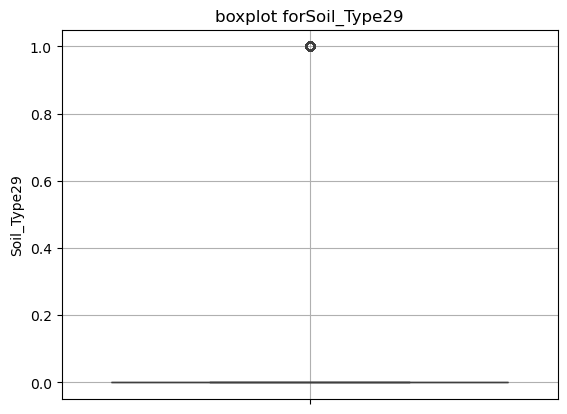

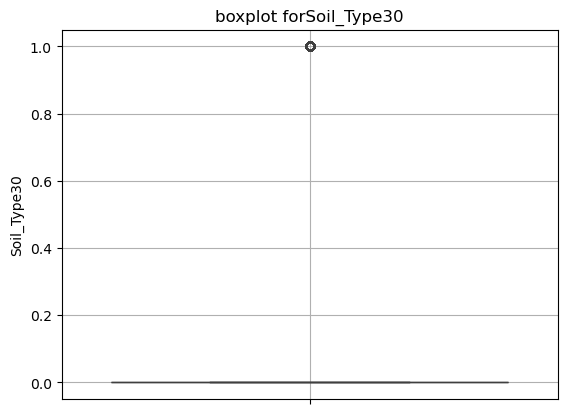

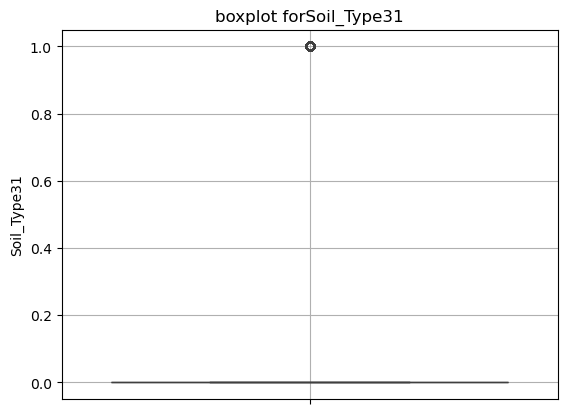

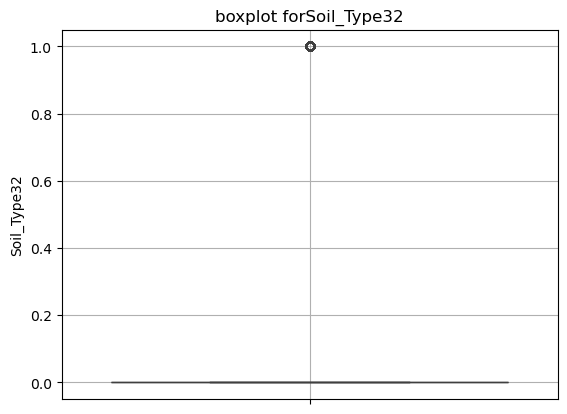

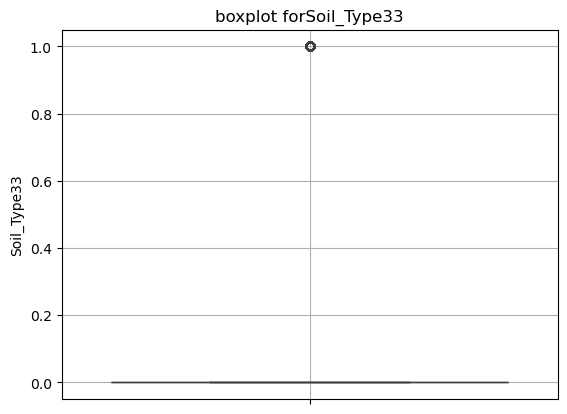

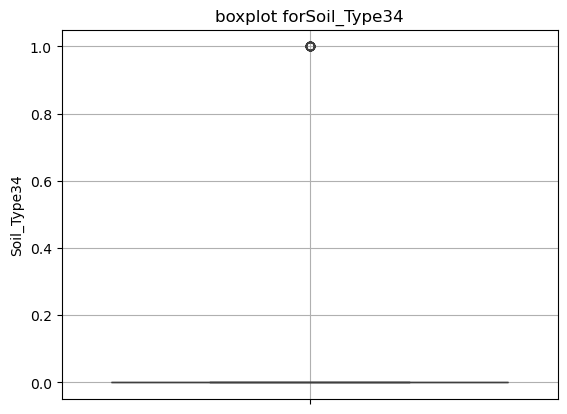

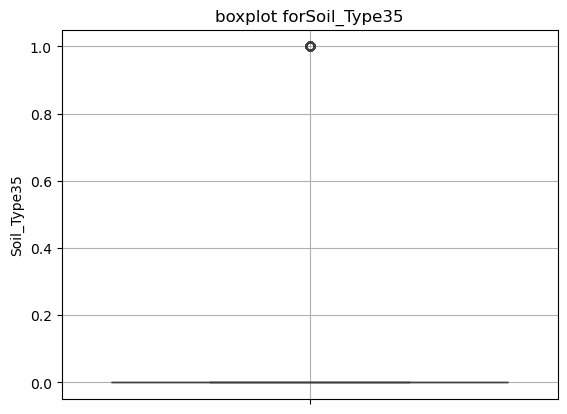

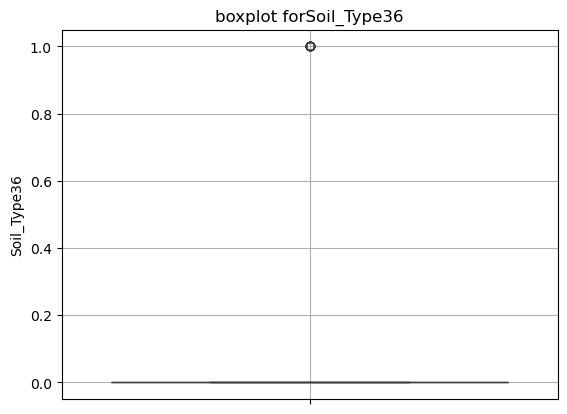

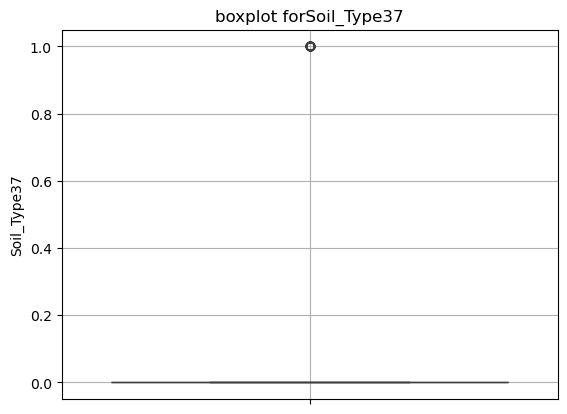

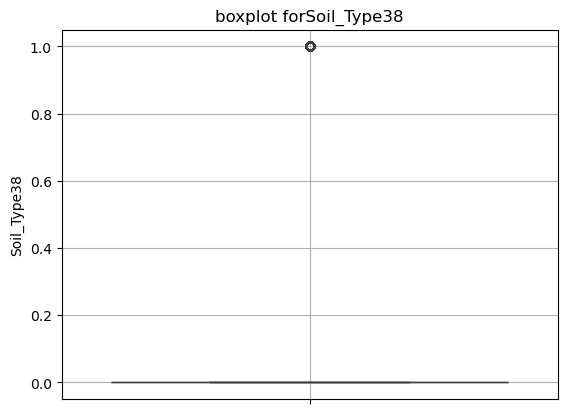

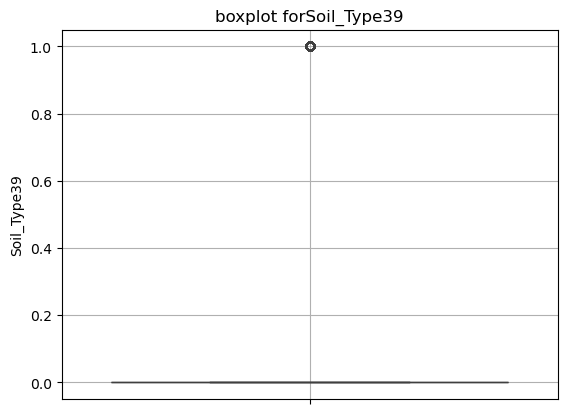

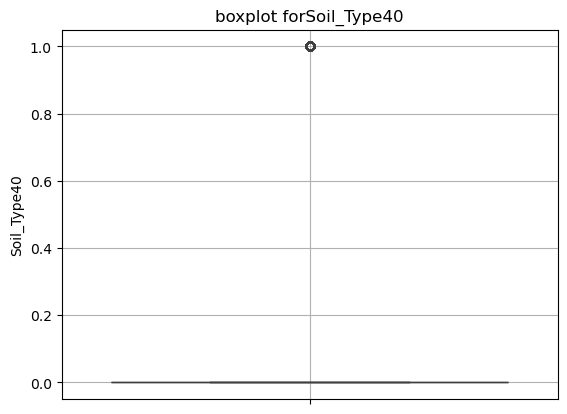

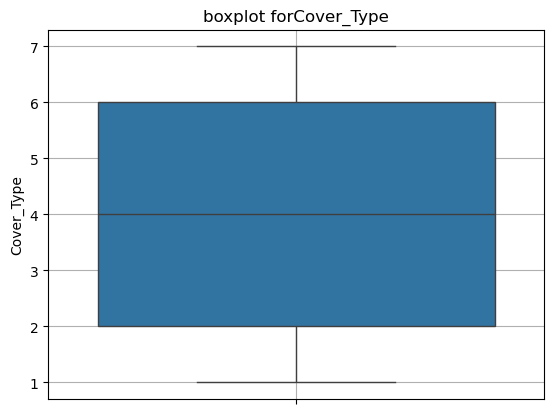

In [6]:
num_col=df.select_dtypes(include='number').columns #handling outliers
for col in num_col:
    sns.boxplot(data=df,y=col)
    plt.title(f'boxplot for{col}')
    plt.grid(True)
    plt.show()

In [7]:
def handling_outliers(df):
    for col in df.select_dtypes(include='number').columns:
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        lower_bound=Q1-(1.5*IQR)
        upper_bound=Q3+(1.5*IQR)
        #Capping
        df[col]=df[col].apply(lambda x:lower_bound if x<lower_bound else upper_bound
                           if x>upper_bound else x)
    return df

In [8]:
df1=handling_outliers(df)
df1

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3.0,258.0,0.0,510.0,221.0,232.0,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2,2590,56,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,3,2804,139,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,4,2785,155,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,5,2595,45,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23.0,258.0,7.0,660.0,170.0,251.0,214.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
15116,15117,2603,121,19.0,633.0,190.0,618.0,249.0,221.0,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
15117,15118,2492,134,25.0,365.0,117.0,335.0,250.0,220.0,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
15118,15119,2487,167,28.0,218.0,101.0,242.0,229.0,237.0,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


<Axes: >

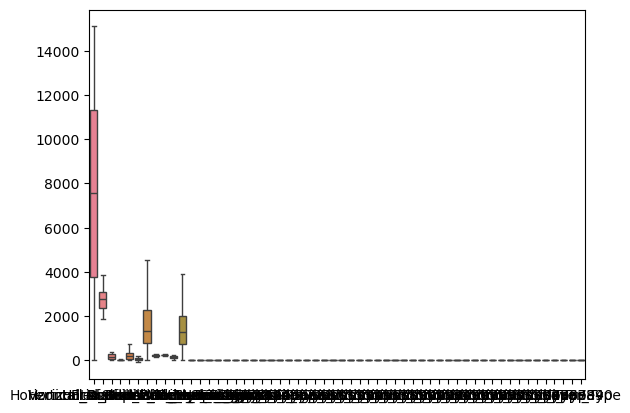

In [9]:
sns.boxplot(data=df1)

In [12]:
# Define target column name (check your dataset for the exact name)
target = 'Cover_Type'   # change if your target column name is different

# Define feature matrix (X) and target vector (y)
X = df1.drop(columns=[target])
y = df1[target]

In [13]:
# Correlation and feature selection
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric features used for correlation:', len(num_features))



Numeric features used for correlation: 55


In [14]:
sample_corr = X[num_features].copy()
if sample_corr.shape[1] > 25:
    sample_corr = sample_corr.iloc[:, :25]



In [15]:
k = min(20, X.shape[1])
selector = SelectKBest(score_func=f_classif, k=k)
X_numeric = X.select_dtypes(include=[np.number]).fillna(0)
selector.fit(X_numeric, y)
scores = pd.Series(selector.scores_, index=X_numeric.columns).sort_values(ascending=False)
print('\nTop features by SelectKBest (ANOVA F-test):')
print(scores.head(20))




Top features by SelectKBest (ANOVA F-test):
Elevation                             16241.233317
Wilderness_Area4                       5072.497908
Horizontal_Distance_To_Roadways        1333.346799
Horizontal_Distance_To_Fire_Points      873.989071
Wilderness_Area3                        444.959975
Hillshade_9am                           383.834100
Horizontal_Distance_To_Hydrology        375.143023
Slope                                   304.802667
Hillshade_3pm                           197.416069
Id                                      182.784839
Hillshade_Noon                          120.693292
Vertical_Distance_To_Hydrology           71.350894
Aspect                                   48.297375
Wilderness_Area1                               NaN
Wilderness_Area2                               NaN
Soil_Type1                                     NaN
Soil_Type2                                     NaN
Soil_Type3                                     NaN
Soil_Type4                           

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_numeric, y)
importances = pd.Series(rf.feature_importances_, index=X_numeric.columns).sort_values(ascending=False)
print('\nTop features by RandomForest importance:')
print(importances.head(20))


Top features by RandomForest importance:
Elevation                             0.251035
Id                                    0.104664
Horizontal_Distance_To_Roadways       0.097480
Horizontal_Distance_To_Fire_Points    0.080345
Horizontal_Distance_To_Hydrology      0.067017
Aspect                                0.060745
Vertical_Distance_To_Hydrology        0.058920
Hillshade_9am                         0.058304
Hillshade_3pm                         0.053944
Wilderness_Area4                      0.053712
Hillshade_Noon                        0.050599
Slope                                 0.041934
Wilderness_Area3                      0.021301
Soil_Type28                           0.000000
Soil_Type27                           0.000000
Soil_Type26                           0.000000
Soil_Type22                           0.000000
Soil_Type25                           0.000000
Soil_Type24                           0.000000
Soil_Type23                           0.000000
dtype: float64


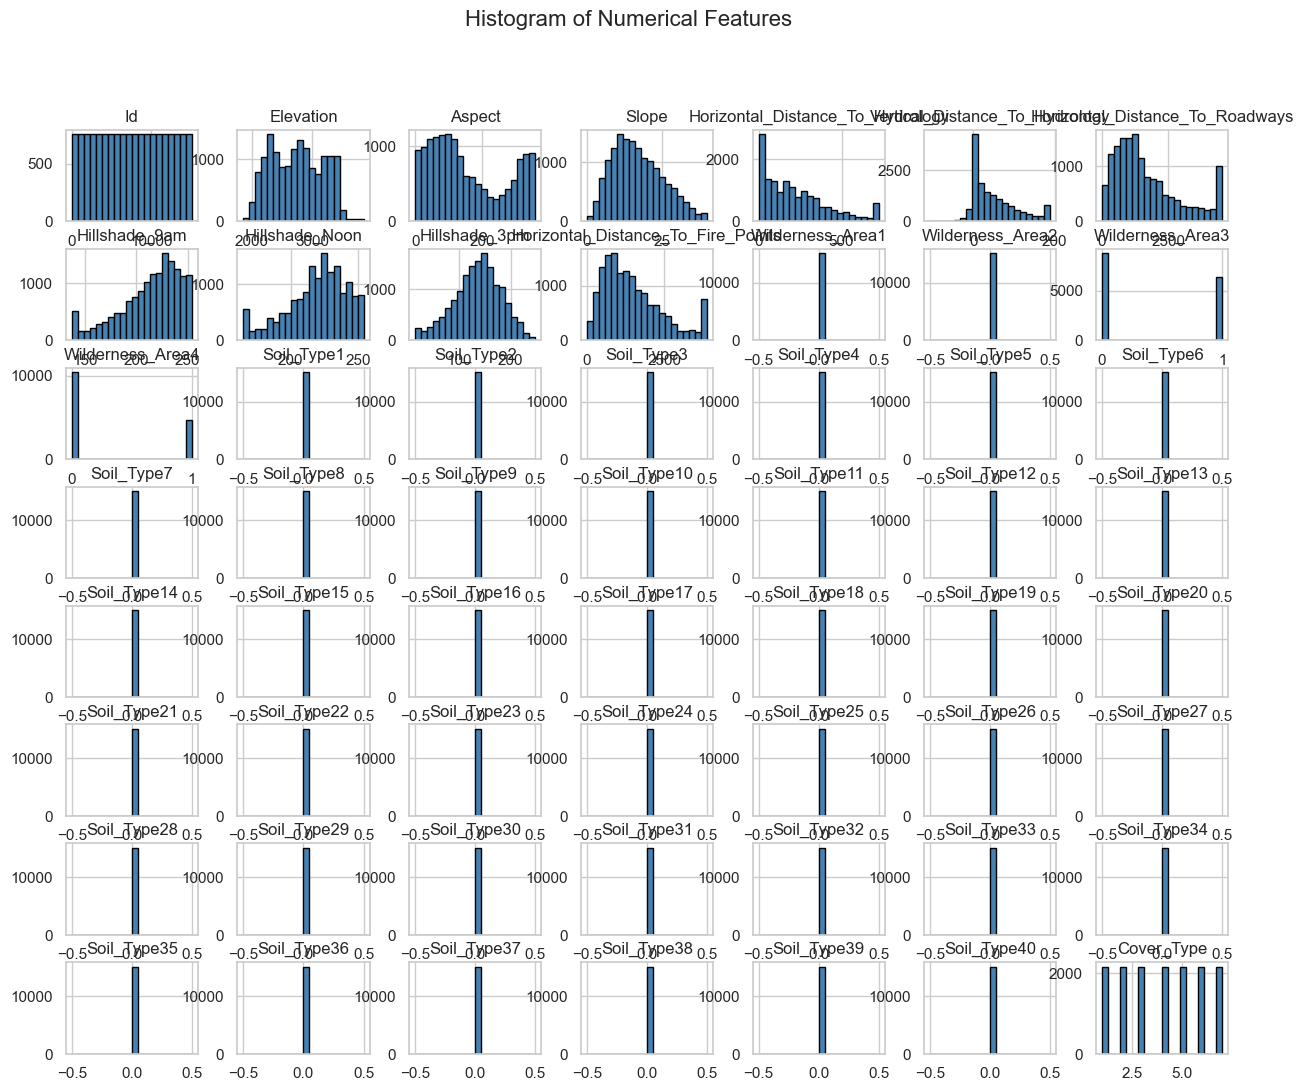

In [18]:

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,5)

# Histogram of numerical features
num_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
df1[num_cols].hist(bins=20, figsize=(15, 12), color='steelblue', edgecolor='black')
plt.suptitle('Histogram of Numerical Features', fontsize=16)
plt.show()

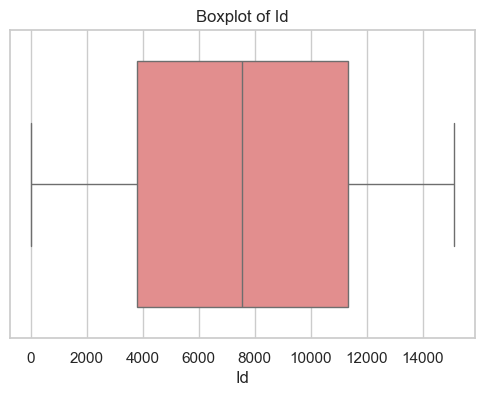

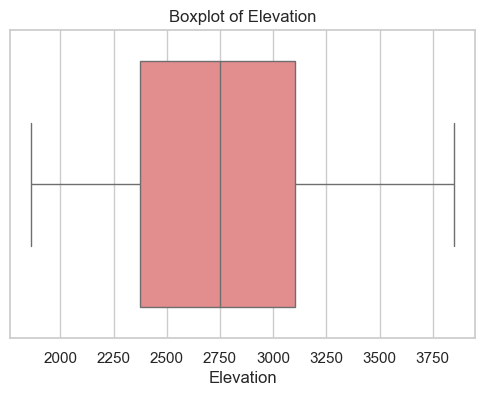

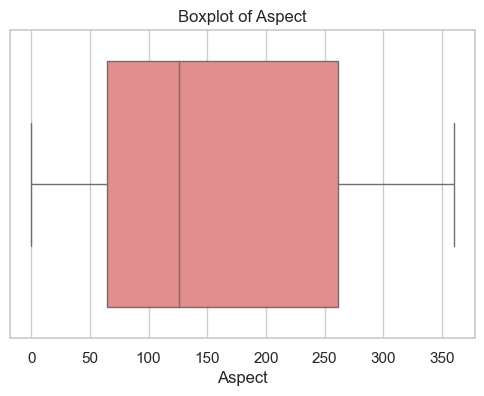

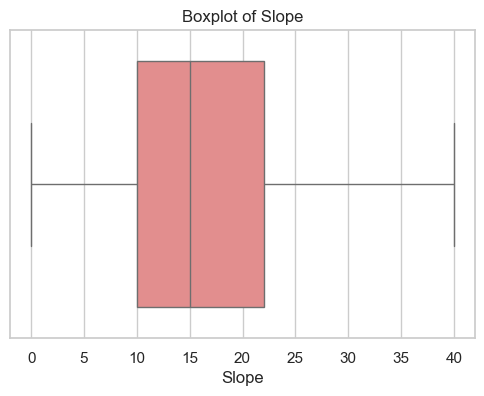

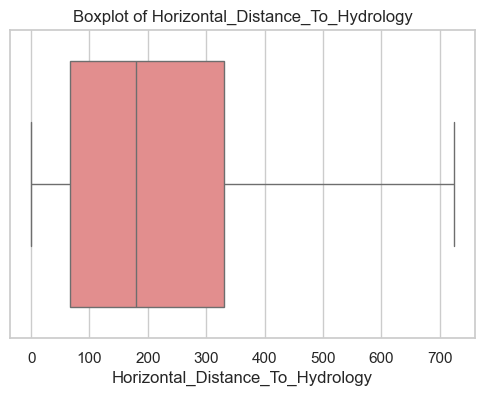

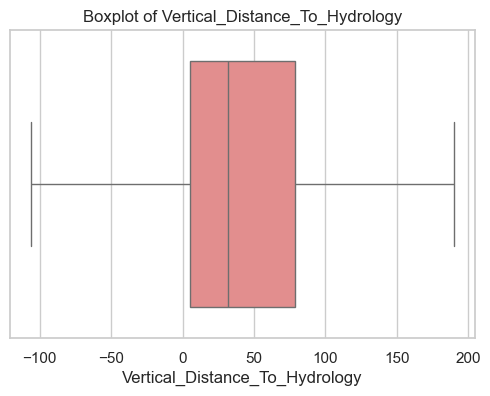

In [19]:
# Boxplots for top numerical features to visualize outliers and spread
top_num = num_cols[:6] if len(num_cols) > 6 else num_cols
for col in top_num:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df1[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')
    plt.show()

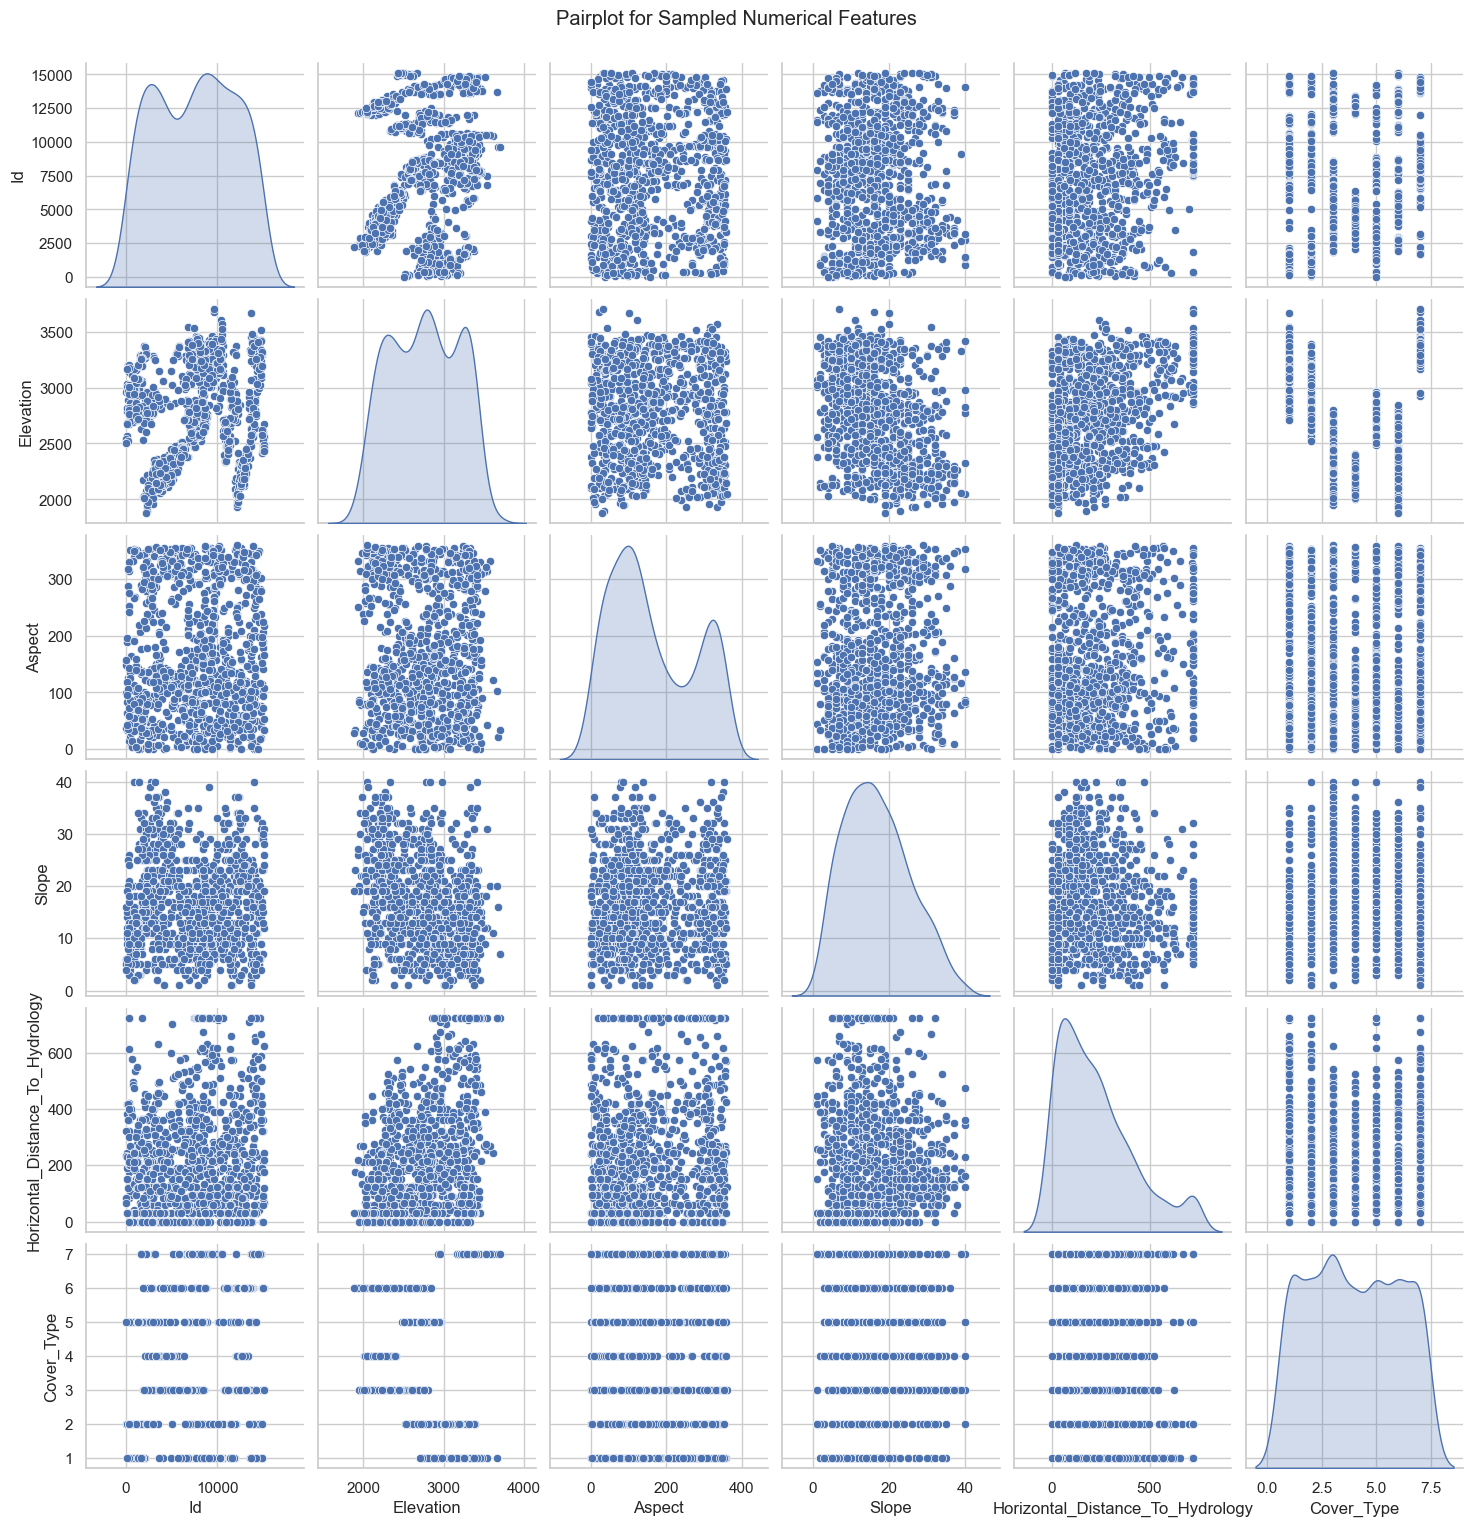

In [20]:
# Pairplot for a sample of numerical features (if dataset large)
if df1.shape[0] > 1000:
    df_sample = df1.sample(1000, random_state=42)
else:
    df_sample = df1.copy()

sns.pairplot(df_sample[num_cols[:5] + [target]], diag_kind='kde')
plt.suptitle('Pairplot for Sampled Numerical Features', y=1.02)
plt.show()

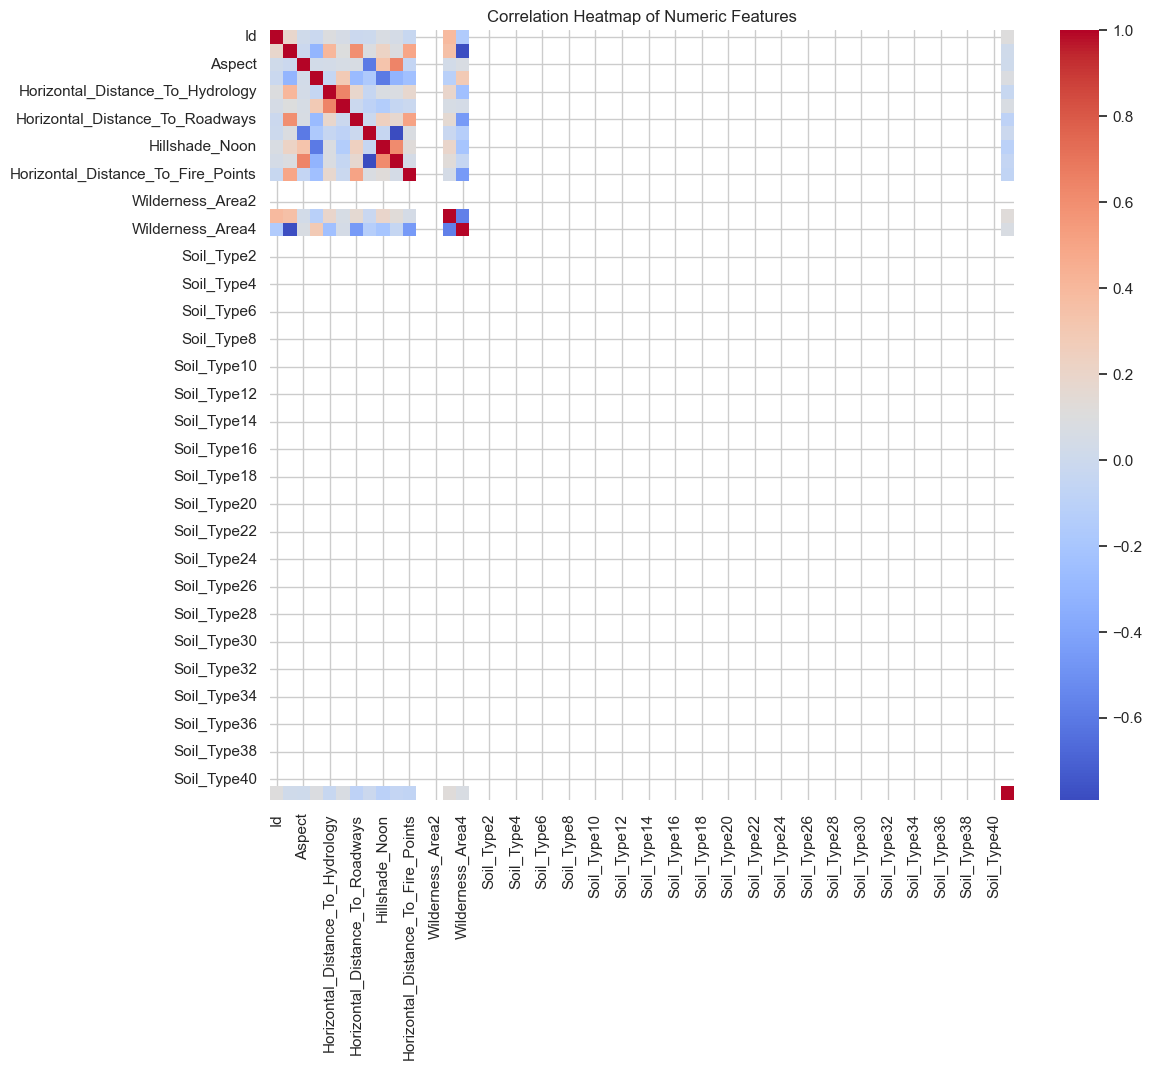

In [21]:
# Correlation heatmap
corr = df1[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

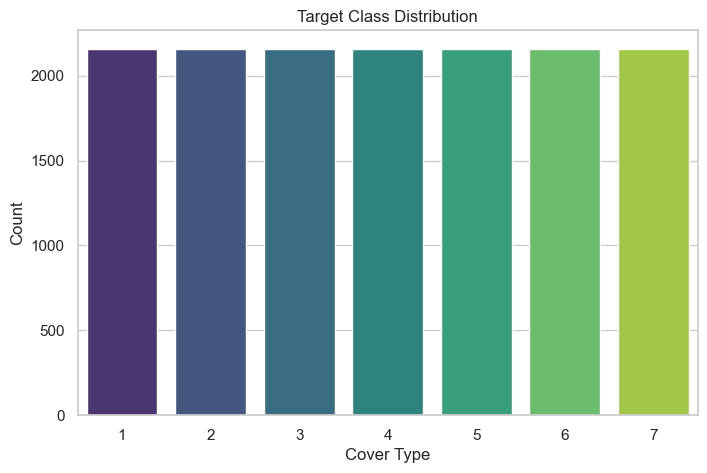

In [22]:
# Target variable distribution
sns.countplot(x=y, palette='viridis')
plt.title('Target Class Distribution')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.show()

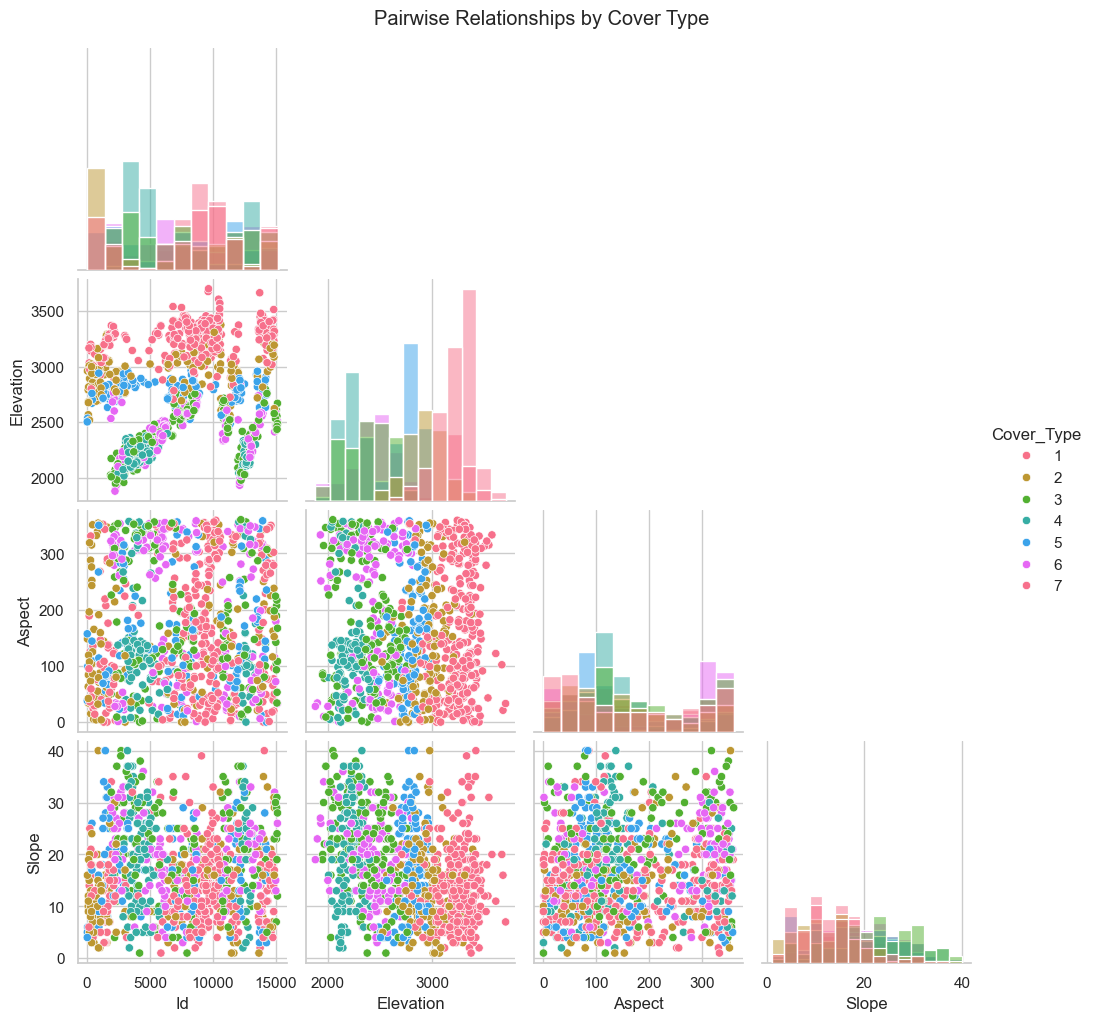

In [23]:
# Pairwise scatterplots colored by target class (first 4 features)
if len(num_cols) >= 4:
    sns.pairplot(df_sample[num_cols[:4] + [target]], hue=target, corner=True, diag_kind='hist', palette='husl')
    plt.suptitle('Pairwise Relationships by Cover Type', y=1.02)
    plt.show()

In [24]:
# Prepare data for modeling
X_model = X_numeric.copy()

X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train shape: (12096, 55) Test shape: (3024, 55)


In [ ]:
# Train and evaluate multiple models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighbors': KNeighborsClassifier(),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    print('\nTraining', name)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print(f'Accuracy on test set: {acc:.4f}')
    print('Classification report:')
    print(classification_report(y_test, preds))
    results[name] = {'model': model, 'accuracy': acc}

res_df = pd.DataFrame({k: {'accuracy': v['accuracy']} for k,v in results.items()}).T.sort_values('accuracy', ascending=False)
print('\nModel comparison:')
display(res_df)

In [ ]:
# Cross-validation and GridSearch for RandomForest (small grid)
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
print('Best model from simple split:', best_model_name)

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
print('RandomForest GridSearch best params:', grid.best_params_)
best_rf = grid.best_estimator_
preds = best_rf.predict(X_test_scaled)
print('Tuned RandomForest test accuracy:', accuracy_score(y_test, preds))
results['RandomForest_Tuned'] = {'model': best_rf, 'accuracy': accuracy_score(y_test, preds)}

final_df = pd.DataFrame({k: {'accuracy': v['accuracy']} for k,v in results.items()}).T.sort_values('accuracy', ascending=False)
print('\nFinal model comparison:')
display(final_df)

best_name = final_df.index[0]
best_model = results[best_name]['model'] if best_name in results else best_rf
joblib.dump(best_model, 'best_forest_cover_model.joblib')
print(f'Saved best model ({best_name}) to best_forest_cover_model.joblib')

## Conclusions & Next steps

- Notebook performed EDA, handled duplicates, missing values, and winsorized numeric outliers.
- Feature selection used SelectKBest and RandomForest importances.
- Multiple classification models were trained and evaluated; the best model (saved to `/mnt/data/best_forest_cover_model.joblib`) can be used for inference.

**Next steps**:
- If categorical features exist, apply One-Hot Encoding and include them.
- Perform more careful hyperparameter tuning using larger search spaces and cross-validation.
- Try XGBoost / LightGBM for potential performance improvements.
- Create a prediction/inference script or API that loads `scaler.joblib` and `best_forest_cover_model.joblib` for production inference.

---

**Files produced by this run:**
- `forest_cover_project.ipynb` — this full notebook
- `best_forest_cover_model.joblib` — saved best model (if training completed)


Open the notebook to view outputs, plots, and results interactively.